In [7]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from imblearn.over_sampling import RandomOverSampler
from gensim.models import Word2Vec
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
# Load the dataset
file_path = '../date/clean_data_filtered.csv'  # Update this path as needed
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

   Release Year                            Title Origin/Ethnicity  \
0          1907  How Brown Saw the Baseball Game         American   
1          1907                     Laughing Gas         American   
2          1908         The Adventures of Dollie         American   
3          1908                  The Black Viper         American   
4          1908           A Calamitous Elopement         American   

               Director                               Cast   Genre  \
0               Unknown                            Unknown  comedy   
1  Edwin Stanton Porter    Bertha Regustus, Edward Boulden  comedy   
2        D. W. Griffith  Arthur V. Johnson, Linda Arvidson   drama   
3        D. W. Griffith                     D. W. Griffith   drama   
4         D.W. Griffith       Harry Solter, Linda Arvidson  comedy   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/How_Brown_Saw_th...   
1  https://en.wikipedia.org/wiki/Laughing_Gas_(fi...

In [9]:
#how many genres do i have in my dataset
genre_counts = data['Genre'].value_counts()
print(genre_counts)

Genre
drama       5841
comedy      4347
horror      1124
action      1087
thriller     955
romance      918
Name: count, dtype: int64


In [10]:
# Preprocessing
# Drop irrelevant columns
data = data.drop(columns=['Wiki Page', 'Director', 'Cast'])

# Encode categorical variables
label_encoder = LabelEncoder()
data['Origin/Ethnicity'] = label_encoder.fit_transform(data['Origin/Ethnicity'])
data['Genre'] = label_encoder.fit_transform(data['Genre'])


In [11]:
# TF-IDF for 'Plot' column
tfidf_vectorizer = TfidfVectorizer(max_features=100)
plot_tfidf = tfidf_vectorizer.fit_transform(data['Plot'].fillna(''))

In [12]:
# Word2Vec for 'Plot' column
tokenized_plots = data['Plot'].fillna('').apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=tokenized_plots, vector_size=100, window=5, min_count=1, workers=4)

In [13]:
def get_plot_embedding(plot):
    embeddings = [word2vec_model.wv[word] for word in plot if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

plot_word2vec = tokenized_plots.apply(get_plot_embedding)
plot_word2vec = np.vstack(plot_word2vec.values)



In [14]:
# TF-IDF for 'Title' column
title_tfidf_vectorizer = TfidfVectorizer(max_features=50)
title_tfidf = title_tfidf_vectorizer.fit_transform(data['Title'].fillna(''))

# Word2Vec for 'Title' column
tokenized_titles = data['Title'].fillna('').apply(lambda x: x.split())
title_word2vec_model = Word2Vec(sentences=tokenized_titles, vector_size=50, window=3, min_count=1, workers=4)

def get_title_embedding(title):
    embeddings = [title_word2vec_model.wv[word] for word in title if word in title_word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(title_word2vec_model.vector_size)

title_word2vec = tokenized_titles.apply(get_title_embedding)
title_word2vec = np.vstack(title_word2vec.values)

In [15]:
# Combine TF-IDF and Word2Vec features for 'Plot' and 'Title'
combined_text_features = np.hstack((plot_word2vec, plot_tfidf.toarray(), title_word2vec, title_tfidf.toarray()))

In [16]:
# Combine numeric and textual features
numeric_features = data[['Release Year', 'Origin/Ethnicity', 'Genre']].values
numeric_features = StandardScaler().fit_transform(numeric_features)
combined_features = np.hstack((numeric_features, combined_text_features))

In [17]:
# Apply RandomOverSampler to balance the data
oversampler = RandomOverSampler(random_state=42)
combined_features_oversampled, labels_oversampled = oversampler.fit_resample(combined_features, data['Genre'])


In [18]:
# Apply Birch Clustering on the oversampled data
birch_model = Birch(n_clusters=7, threshold=0.3, branching_factor=50)
birch_model.fit(combined_features_oversampled)

# Get cluster labels for the oversampled data
oversampled_cluster_labels = birch_model.labels_

In [19]:
def map_labels(true_labels, cluster_labels):
    # Create the contingency matrix
    contingency_matrix = pd.crosstab(true_labels, cluster_labels)
    
    # Perform the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.values)
    
    # Create the mapping from cluster labels to true labels
    mapping = {col: row_ind[i] for i, col in enumerate(col_ind)}
    
    # Map cluster labels using the mapping, return -1 for unmapped labels
    return [mapping.get(label, -1) for label in cluster_labels]


In [20]:
# Map cluster labels to true labels
mapped_labels = map_labels(labels_oversampled, birch_model.labels_)

# Calculate cluster accuracy
cluster_accuracy = accuracy_score(labels_oversampled, mapped_labels)
print(f"Cluster Accuracy: {cluster_accuracy}")

# Evaluate clustering performance
# Silhouette Score
silhouette_avg = silhouette_score(combined_features_oversampled, birch_model.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(labels_oversampled, birch_model.labels_)
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(labels_oversampled, birch_model.labels_)
print(f"Normalized Mutual Information (NMI): {nmi_score}")

Cluster Accuracy: 0.5220281915197169
Silhouette Score: 0.10758220490971272
Adjusted Rand Index (ARI): 0.3619645255726839
Normalized Mutual Information (NMI): 0.4847531809068211


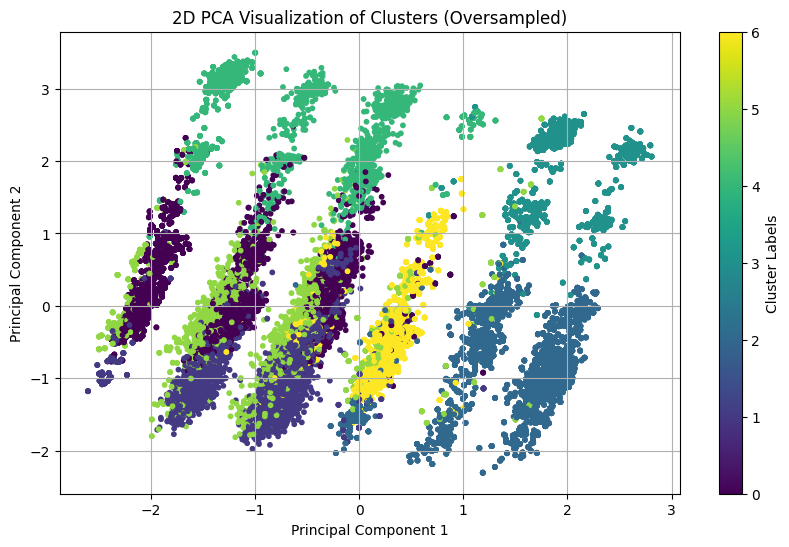

In [24]:
# Reduce features to 2D for visualization using PCA
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(combined_features_oversampled)

# 2D scatter plot of clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], c=birch_model.labels_, cmap='viridis', s=10)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("2D PCA Visualization of Clusters (Oversampled)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

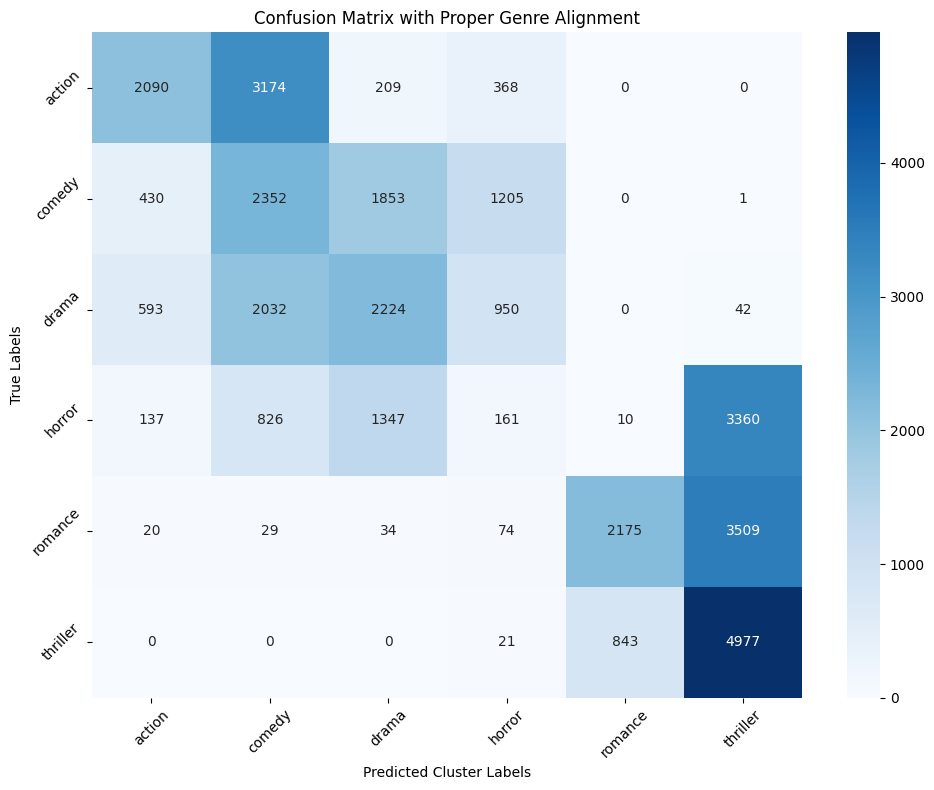

In [50]:
# Remove noise points (if -1 exists in cluster labels)
valid_indices = np.array(mapped_labels) != -1
filtered_labels = labels_oversampled[valid_indices]
filtered_mapped_labels = np.array(mapped_labels)[valid_indices]

# Decode genre names aligned with unique true labels
genre_names = label_encoder.inverse_transform(np.unique(filtered_labels))

# Generate the confusion matrix
conf_matrix = confusion_matrix(filtered_labels, filtered_mapped_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genre_names, yticklabels=genre_names)
plt.title("Confusion Matrix with Proper Genre Alignment")
plt.xlabel("Predicted Cluster Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
